In [1]:
from functools import partial

import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as np
import matplotlib.pyplot as plt

from burst import (
    infft,
    segment_times,
    signal,
    simulate_complex,
    simulate_event,
)

%matplotlib inline

In [2]:
prng_key = jax.random.PRNGKey(0)
duration = 4
sample_rate = 256
times = segment_times(duration, sample_rate)

population_size = 1000

# Build a complex SVD basis for sine Gaussian singals

Simulate complex signals to model all possible phases with the phase parameter set to zero and no time offset.

Perform an SVD on this basis, filtering is then done as a multistage process:

- choose a subset of the basis with large eigenvalues to avoid overfitting noise.
- convolve the data with the real and imaginary components of the basis maximize over the unknown phase and time.
- realign the maximum time with zero.
- apply the filter.
- If the original time is important, realign the time back to the start point, otherwise leave it at zero.

In [3]:
svd_bounds = dict(
    amplitude=(10, 80),
    frequency=(1, 9),
    bandwidth=(0.3, 0.7),
)

subkeys = jax.random.split(prng_key, population_size)
mean_frequency = 5.0
sigma_frequency = 3
signals = jax.vmap(partial(
    simulate_complex,
    mean_frequency=mean_frequency,
    sigma_frequency=sigma_frequency,
    bounds=svd_bounds,
    sample_rate=sample_rate,
    times=times,
))(np.array(subkeys))

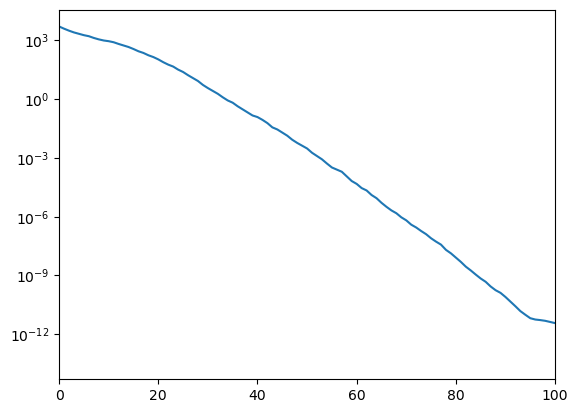

In [4]:
u, s, v = np.linalg.svd(signals, full_matrices=False)
plt.plot(s)
plt.yscale("log")
plt.xlim(0, 100)
plt.show()
plt.close()

(1000, 1000) (1000, 1024) (1000,) (1024,)


/Users/colmtalbot/mambaforge/envs/direct-inference/lib/python3.11/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/colmtalbot/mambaforge/envs/direct-inference/lib/python3.11/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


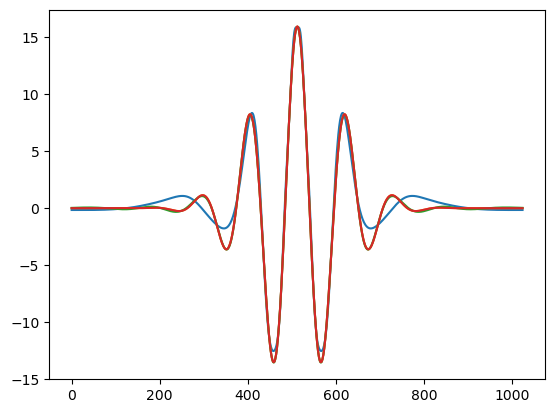

(Array(1174, dtype=int64),
 Array(1174, dtype=int64),
 Array(31.58785688, dtype=float64),
 Array(41.86540612, dtype=float64),
 Array(41.85890484, dtype=float64),
 Array(41.85890484, dtype=float64))

In [5]:
print(u.shape, v.shape, s.shape, signals[0].shape)

temp = np.roll(signals[0], 150)

for truncation in [10, 20, 50, 100, 200, 500, 1000][:2]:

    U = jax.vmap(lambda mode: np.convolve(temp, mode, mode="full") / len(mode))(v[:truncation])

    # plt.plot(abs((u[:, :truncation] * s[:truncation] @ U)[0]))
    # plt.plot((s[:truncation, None] * abs(U)**2).sum(axis=0) / 4)
    # print(U.shape)
    shift = np.argmax((s[:truncation, None] * abs(U)**2).sum(axis=0) / 4)
    plt.plot(v[:truncation].T @ v[:truncation].conjugate() @ np.roll(temp, -shift))
    plt.plot(signals[0])
plt.show()
plt.close()

(
    np.argmax((s[:truncation, None] * abs(U)**2).sum(axis=0) / 4),
    np.argmax(abs((u[:, :truncation] * s[:truncation] @ U)[0])),
    (s[:truncation] * abs(v[:truncation].conjugate() @ signals[0] / len(signals[0]))**2).sum() / 4,
    abs((signals[0])**2).mean(),
    abs((v[:truncation].T @ v[:truncation].conjugate() @ np.roll(temp, -shift))**2).mean(),
    (abs(v[:truncation].conjugate() @ np.roll(temp, -shift))**2).sum() / len(temp),
)
# abs(v[:truncation] @ signals[0])

# U.shape

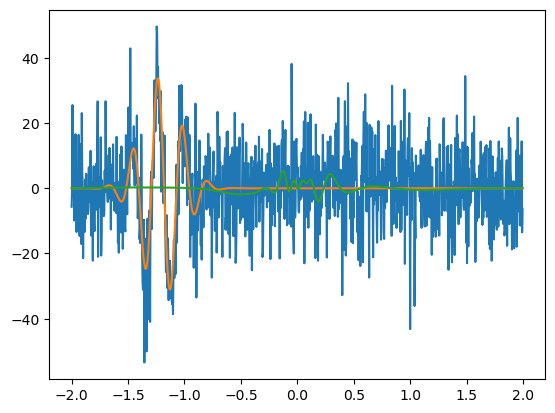

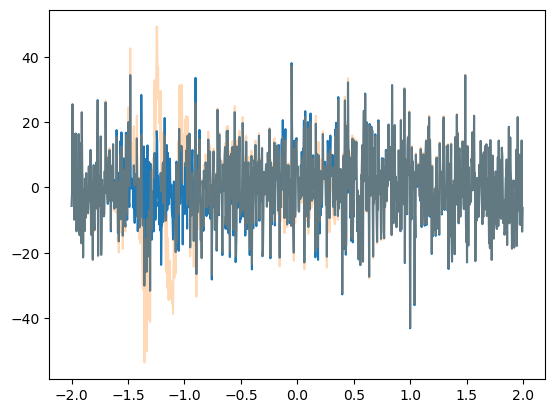

95.47797234363604 94.62992006935826


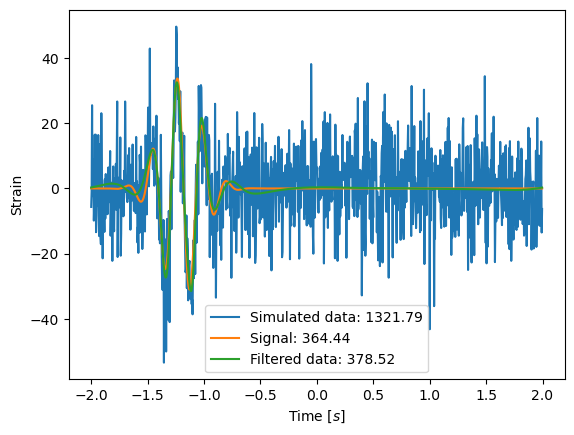

95.47797234363604 94.62992006935826


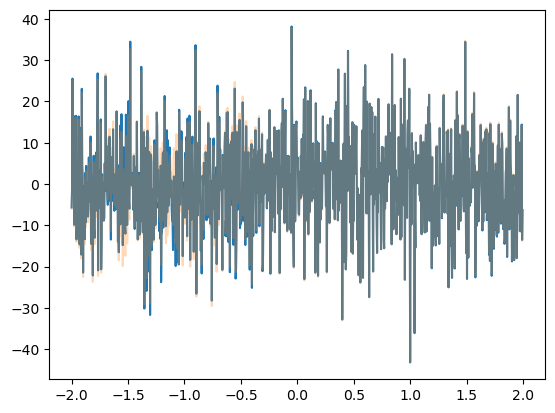

95.47797234363604 94.62992006935826


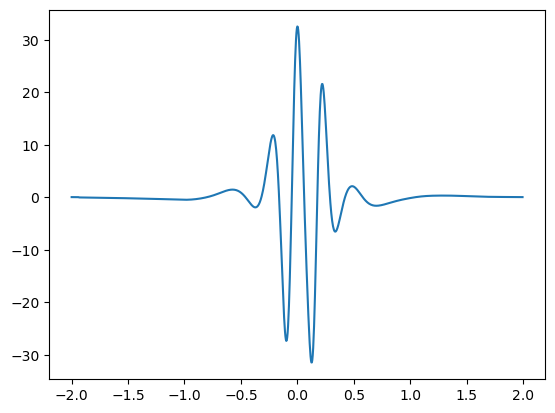

In [6]:
test_bounds = dict(
    amplitude=(10, 80),
    frequency=(1, 9),
    bandwidth=(0.3, 0.7),
    phase=(0, np.pi),
    delta_t=(0.8, 1.3),
)
fd_data, parameters = simulate_event(
    jax.random.PRNGKey(20),
    5.0,
    0.5,
    bounds=test_bounds,
    sample_rate=sample_rate,
    duration=duration,
    times=times
)
sig = signal(parameters, times=times, sample_rate=sample_rate).squeeze()
new_data = infft(fd_data, sample_rate=sample_rate)
# new_data = sig

truncation = 8

basis = v[:truncation]

plt.plot(times, new_data)
plt.plot(times, sig)
# for n_templates in [5, 10, 20, 40]:
#     filter = v[:n_templates]
plt.plot(times, 2 * (basis @ new_data @ basis.conjugate()).real)
plt.show()
plt.close()


plt.plot(times, new_data - sig)
# for n_templates in [5, 10, 20, 40]:
#     filter = v[:n_templates]
plt.plot(times, new_data - 2 * (basis @ new_data @ basis.conjugate()).real, alpha=0.3)
plt.show()
plt.close()


weights = s[:truncation, None]


# @jax.jit
def apply_filter(data, basis, weights):
    U = jax.vmap(lambda mode: np.convolve(np.roll(data, 10), mode, mode="full") / len(mode))(basis)
    snr_time_series = (weights * abs(U)**2).sum(axis=0)
    shift = len(snr_time_series) // 2 - np.argmax(snr_time_series)
    filtered = 2 * basis.T @ basis.conjugate() @ np.roll(data, shift)
    print(max(snr_time_series), (abs(filtered)**2).sum() / len(data))
    return np.roll(filtered, -shift).real


@jax.jit
def apply_filter_2(data, basis, projection, shift=False):
    if shift:
        U = projection @ data / len(data)
        snr_time_series = (abs(U)**2).sum(axis=0)
        delta = - np.argmax(snr_time_series)
        data = np.roll(data, delta)
    else:
        delta = 0
    filtered = 2 * basis.conjugate() @ data
    snr = (abs(filtered)**2).sum() / len(data)
    return filtered, snr**0.5, delta


def time_align(data):
    shift = len(data) // 2 - np.argmax(data)
    return np.roll(data, shift)


plt.plot(times, new_data, label=f"Simulated data: {np.sum(abs(new_data)**2 * 2 / sample_rate):.2f}")
plt.plot(times, sig, label=f"Signal: {np.sum(abs(sig)**2 * 2 / sample_rate):.2f}")
# for n_templates in [5, 10, 20, 40]:
#     filter = v[:n_templates]
filtered = apply_filter(new_data, basis, weights)
plt.plot(times, filtered, label=f"Filtered data: {np.sum(abs(filtered)**2 * 2 / sample_rate):.2f}")
plt.xlabel("Time [$s$]")
plt.ylabel("Strain")
plt.legend(loc="best")
plt.show()
plt.close()

plt.plot(times, new_data - sig)
# for n_templates in [5, 10, 20, 40]:
#     filter = v[:n_templates]
filtered = apply_filter(new_data, basis, weights)
plt.plot(times, new_data - filtered, alpha=0.3)
plt.show()
plt.close()

# for n_templates in [5, 10, 20, 40]:
#     filter = v[:n_templates]
filtered = apply_filter(new_data, basis, weights)
plt.plot(times, time_align(filtered))
plt.show()
plt.close()

In [139]:
import dill

with open("sinegaussian_svd.pkl", "wb") as ff:
    dill.dump((u, s, v), ff)